In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import os
import sys
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)
    
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)
from AOE.gp_bandit import gp_bandit_finance, Wasserstein_GP_mean, ExactGPModel

/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GpGenerator:
    def __init__(self, train_x, train_y, lengthscale = None):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise = 1e-4
        likelihood.noise_covar.raw_noise.requires_grad_(False)
        self.model = ExactGPModel(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float), likelihood = likelihood, lengthscale=lengthscale)
        
    def sample_posterior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        self.model.add_point(x, y)
        return y
        
    def sample_prior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        return y
    
def normalize_regret(x):
    return (torch.tanh(x) + 1)/2

# Synthetic Experiment

In [3]:
strategies  = {'arm1' : {'contextual_params': {'feature_name'  : 'feature'}},
               'arm2' : {'contextual_params': {'feature_name'  : 'feature'}}}
seed = 2
torch.manual_seed(seed)

In [4]:
# Parameters bandit
size_buffer   = 1000
size_window   = 16
size_subwindow   = 8
training_iter = 30
bandit_params = 0.1
type_1_error = 0.05
likelihood    = gpytorch.likelihoods.GaussianLikelihood()
bandit_algo   = 'TS'
threshold = 2*type_1_error
bandit = gp_bandit_finance(strategies, bandit_algo=bandit_algo, bandit_params=bandit_params, training_iter=training_iter, size_buffer=size_buffer, size_window=size_window, size_subwindow=size_subwindow, type_1_error=type_1_error, threshold = threshold)

In [5]:
# Parameters environment
T = 400
N = 2
T_N = T//N
reward1 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
reward2 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
def generate_x():
    x_new = 2*torch.rand(1) - 1
    return x_new, pd.Series(data={'feature': x_new}, index=['feature'])

  0%|          | 0/200 [00:00<?, ?it/s]/home/pierre/miniconda3/envs/exec/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
100%|██████████| 200/200 [00:18<00:00, 10.85it/s]


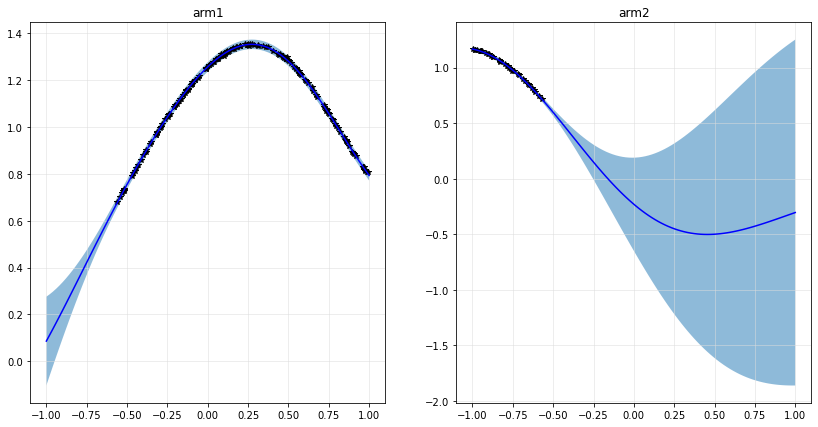

  0%|          | 0/200 [00:00<?, ?it/s]

Change point detected
Value R, tau1, error2 (tensor(2911.5367, dtype=torch.float64, grad_fn=<AddBackward0>), tensor([27.2101], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([0.7201], dtype=torch.float64, grad_fn=<MaximumBackward0>))


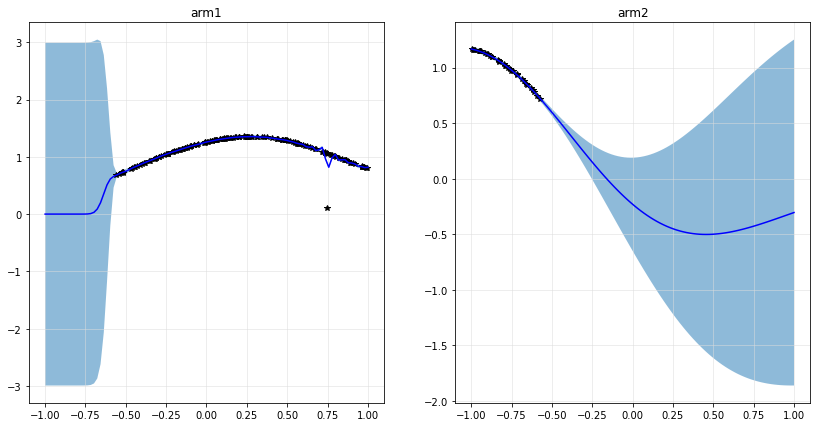

  0%|          | 1/200 [00:00<01:03,  3.12it/s]

Regime change detected every arms are reinitialized


100%|██████████| 200/200 [00:17<00:00, 11.31it/s]


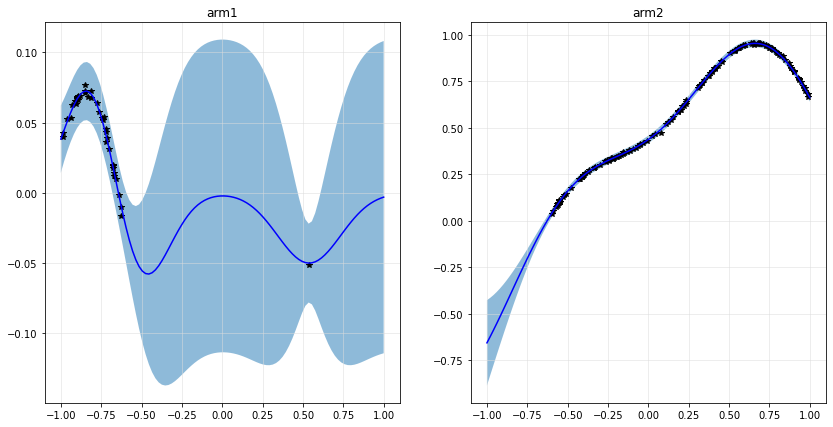

In [6]:
#### Debug change point

# Simulation bandit
regret_sim = torch.zeros(T)
for i in range(N):
    
    # New underlying reward distribution for both arms
    reward1 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    reward2 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    for t in tqdm(range(T_N)):
        x_new, df_new = generate_x()
        best_strategy_bandit  = bandit.select_best_strategy(df_new)
        r1, r2 = reward1.sample_posterior(x_new), reward2.sample_posterior(x_new)
        
        if best_strategy_bandit == "arm1":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r1)
            bandit.update_data(df_new, best_strategy_bandit, r1, retrain_hyperparameters = True)
            
        elif best_strategy_bandit == "arm2":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r2)
            bandit.update_data(df_new, best_strategy_bandit, r2, retrain_hyperparameters = True)
        
        change_point = bandit.change_point(best_strategy_bandit)
        if change_point != False:
            if change_point[0]:
                print("Change point detected")
                print("Value R, tau1, error2", change_point[1:])
                bandit.plot_strategies()
                bandit.reinitialize_arm()
        regret_sim[i*T_N + t] = regret_t
    bandit.plot_strategies()

100%|██████████| 200/200 [00:18<00:00, 10.74it/s]


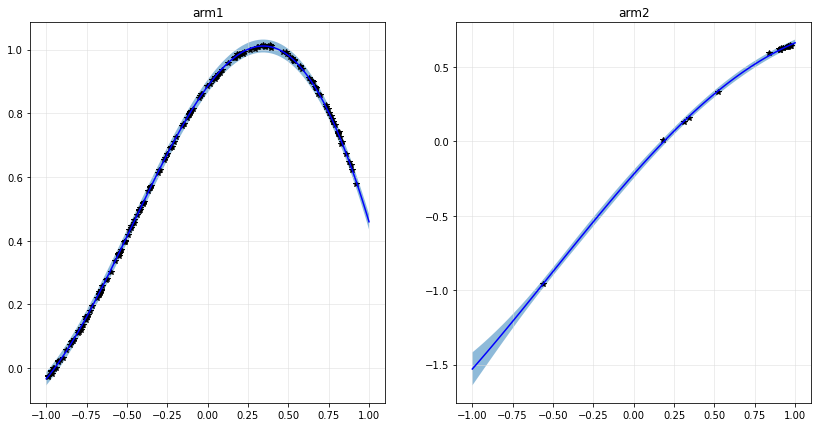

100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


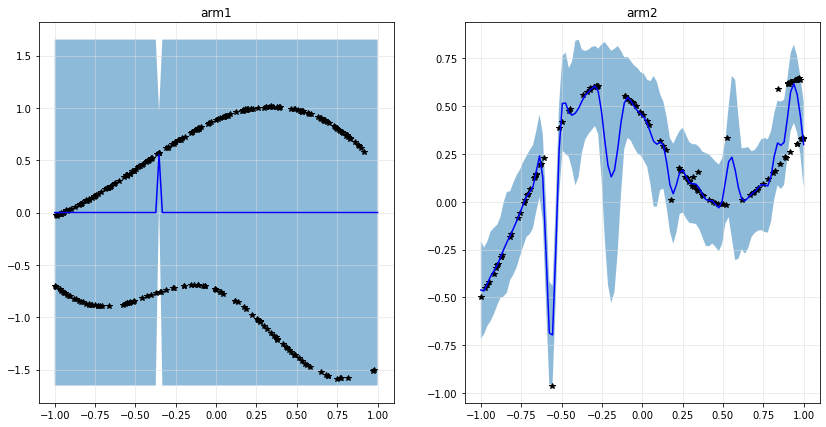

In [7]:
bandit = gp_bandit_finance(strategies, bandit_algo=bandit_algo, bandit_params=bandit_params, training_iter=training_iter, size_buffer=size_buffer, size_window=size_window, size_subwindow=size_subwindow, type_1_error=type_1_error, threshold = threshold)
# Simulation bandit
regret_sim = torch.zeros(T)
for i in range(N):
    
    # New underlying reward distribution for both arms
    reward1 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    reward2 = GpGenerator(train_x = torch.zeros((0, 1), dtype=torch.float), train_y = torch.zeros(0, dtype=torch.float))
    for t in tqdm(range(T_N)):
        x_new, df_new = generate_x()
        best_strategy_bandit  = bandit.select_best_strategy(df_new)
        r1, r2 = reward1.sample_posterior(x_new), reward2.sample_posterior(x_new)
        
        if best_strategy_bandit == "arm1":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r1)
            bandit.update_data(df_new, best_strategy_bandit, r1, retrain_hyperparameters = True)
            
        elif best_strategy_bandit == "arm2":
            regret_t = normalize_regret(torch.max(r1, r2)) - normalize_regret(r2)
            bandit.update_data(df_new, best_strategy_bandit, r2, retrain_hyperparameters = True)
        
        change_point = bandit.change_point(best_strategy_bandit)
        if change_point != False:
            if change_point[0]:
                print("Change point detected")
                print("Value R, tau1, error2", change_point[1:])
                bandit.plot_strategies()
                bandit.reinitialize_arm()
        regret_sim[i*T_N + t] = regret_t
    bandit.plot_strategies()

# Non Stationary two square functions

In [20]:
# Parameters bandit
size_buffer   = 1000
size_window   = 16
size_subwindow   = 8
training_iter = 30
bandit_params = 0.1
type_1_error = 0.05
likelihood    = gpytorch.likelihoods.GaussianLikelihood()
bandit_algo   = 'TS'
threshold = 2*type_1_error
bandit = gp_bandit_finance(strategies, bandit_algo=bandit_algo, bandit_params=bandit_params, training_iter=training_iter, size_buffer=size_buffer, size_window=size_window, size_subwindow=size_subwindow, type_1_error=type_1_error, threshold = threshold)

In [21]:
%matplotlib inline

## Plot both gp and value ucb at each time step with data point
## Try non stationarity
## Create synthetic random datapoints
size_window = 14
bandit = gp_bandit_finance(strategies, size_window=size_window)
reward_1 = lambda x: x**2
reward_2 = lambda x: -x**2 + 1
d = {'vol_50_50000': np.random.normal()}

distances = []

for i in range(30):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    reward = reward_1(d['vol_50_50000'])
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    
    bandit.plot_strategies(["imbalance"])
    if i > size_window:
        
        posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_confidence("imbalance")
        test_x = torch.linspace(-1, 1, 100).double()
        f, ax = plt.subplots(1, 1)

        ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
        ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')
        
        posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window_covar("imbalance")
        
        distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        distances.append(distance)
        
        ax.set_title(f"Wasserstein distance: distance {distance}")
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
        #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)

print("---------------Change of regime!!!! ------------------")
for i in range(30):
    d['vol_50_50000'] = 2*np.random.random() - 1
    feature_values = pd.Series(data=d, index=['vol_50_50000'])
    best_strategy_bandit  = bandit.select_best_strategy(feature_values)
    
    reward = reward_2(d['vol_50_50000'])
    
    bandit.update_data(feature_values, best_strategy_bandit, reward, retrain_hyperparameters = True)
    bandit.plot_strategies(["imbalance"])
    
    posterior_mean_1, lower1, upper1, posterior_mean_2, lower2, upper2 = bandit.posterior_sliding_window_confidence("imbalance")
    test_x = torch.linspace(-1, 1, 100).double()
    f, ax = plt.subplots(1, 1)

    ax.plot(test_x.numpy(), posterior_mean_1.numpy(), 'b')
    ax.plot(test_x.numpy(), posterior_mean_2.numpy(), 'r')

    posterior_mean_1, posterior_covar_1, posterior_mean_2, posterior_covar_2 = bandit.posterior_sliding_window_covar("imbalance")

    distance = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
    distances.append(distance)

    ax.set_title(f"Wasserstein distance: distance {distance}")
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower1.detach().numpy(), upper1.detach().numpy(), alpha=0.5)
    ax.fill_between(test_x.numpy(), lower2.detach().numpy(), upper2.detach().numpy(), alpha=0.5)
    #bandit.change_point(strat, n_test = 100, lv = -1, uv = 1)
        
plt.plot(distances)

KeyError: 'feature'